In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.metrics import roc_auc_score
import joblib

# Cofigure tunable params

In [2]:
mu_values = np.arange(0,50)/10
plotDir = "plots/Toy/"
nBins = 10
aug_NN = False # if training NN for data augmentation instead of LDA- feature removed

In [3]:
useAuxZMeasure = False
#useAuxZMeasure = True

if useAuxZMeasure:
    plotDir = "plots/Toy/AuxMeasure/"

In [4]:
clfCol = "b"; aweCol = "g"; augCol = "y"; invCol = "r"; clfNomCol = "k"

In [5]:
n_events = n_z = 2 * 10**6 # dataset size per z
feature_std = 0.7; r = 1. 

z_nominal = np.pi/4


# TF GPU settings

In [6]:
onlyCPU = False
onlyCPU = True


import os
import tensorflow as tf

if onlyCPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2023-05-19 14:13:24.634990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 14:13:24.911266: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-19 14:13:24.911324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid004242): /proc/driver/nvidia/version does not exist


# Generate Dataset

In [7]:
X_sig_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T])
Y_sig_syst = np.array([np.ones(n_events)])
centres_sig_syst = np.array([r* np.vstack([np.cos(z_nominal), np.sin(z_nominal)]).T])
X_sig_syst += centres_sig_syst

X_back_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T])
Y_back_syst = np.array([np.zeros(n_events)])
centres_back_syst = np.array([r* np.vstack([-np.cos(z_nominal), -np.sin(z_nominal)]).T])
X_back_syst += centres_back_syst

X_syst = np.concatenate([X_sig_syst,X_back_syst], 1)
Y_syst = np.hstack([Y_sig_syst,Y_back_syst])


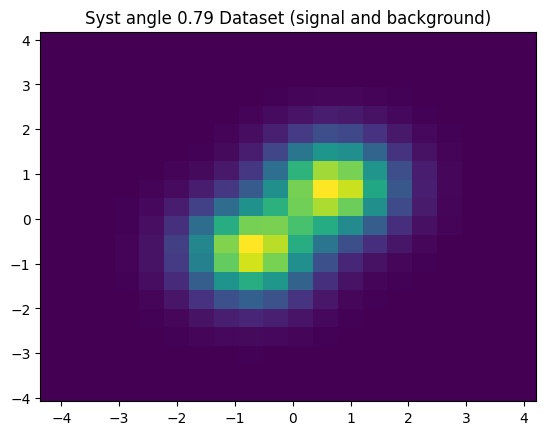

In [8]:
plt.hist2d(X_syst[0,:,0], X_syst[0,:,1], bins=20)
plt.title("Syst angle {} Dataset (signal and background)".format(np.round(z_nominal,2)))
#plt.savefig(plotDir + "systDown_dataset.pdf")
plt.show()

In [9]:
X_syst = X_syst.reshape(-1,X_syst.shape[-1])
Y_syst = Y_syst.reshape(-1)


## Shuffle and split train test

In [10]:
from sklearn.model_selection import train_test_split
X_syst_train, X_syst_test, Y_syst_train, Y_syst_test  = train_test_split(X_syst,Y_syst, shuffle=True)
print(X_syst_train.shape, X_syst_test.shape, Y_syst_train.shape, Y_syst_test.shape)

(3000000, 2) (1000000, 2) (3000000,) (1000000,)


## Save Load datasets

## Calc indices

## Contour plot of data

/tmp/ipykernel_22592/1013750649.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which="major")


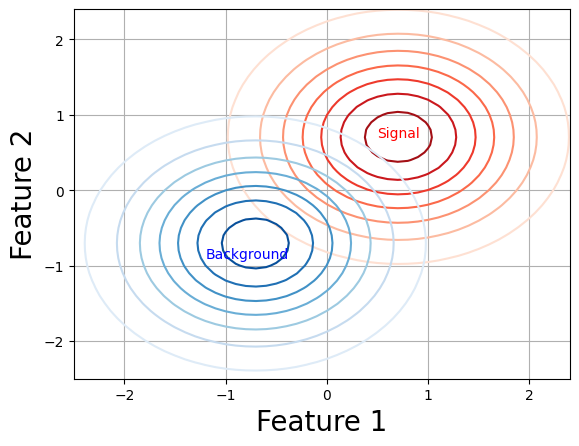

In [11]:
from scipy.stats import multivariate_normal

# Contour plots
lims = 2.5
x, y = np.mgrid[-lims:lims:.1, -lims:lims:.1]
pos = np.dstack((x, y))
signal_pdf = multivariate_normal([np.cos(np.pi/4), np.sin(np.pi/4)], [[0.7, 0], [0, 0.7]])
back_pdf = multivariate_normal([-np.cos(np.pi/4), -np.sin(np.pi/4)], [[0.7, 0], [0, 0.7]])
plt.contour(x, y, signal_pdf.pdf(pos), cmap="Reds")
plt.text(0.5,0.7, "Signal", color="Red")
plt.contour(x, y, back_pdf.pdf(pos), cmap="Blues")
plt.text(-1.2,-0.9, "Background", color="Blue")
plt.grid(b=True, which="major")

plt.xlabel("Feature 1", fontsize="20")
plt.ylabel("Feature 2", fontsize="20")


#plt.savefig(plotDir + "Toy_Nominal_Dataset_Countour.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

# Train/Define Models

## Clf on Nominal

In [12]:
class nominalModel:
    def predict(self,X):
        from scipy.stats import multivariate_normal
        angle = np.pi/4
        rv_signal = multivariate_normal((np.cos(angle),np.sin(angle)),(feature_std,feature_std)).pdf
        rv_back = multivariate_normal((-np.cos(angle),-np.sin(angle)),(feature_std,feature_std)).pdf
        score = rv_signal(X)/(rv_signal(X) + rv_back(X))
        return score
nominal_model = nominalModel()

In [13]:
Y_predict_nomOnnom = nominal_model.predict(X_syst_test).reshape(-1)


In [14]:
print ("Test AUC nom on nom: ", roc_auc_score(y_true=Y_syst_test, y_score=Y_predict_nomOnnom))


Test AUC nom on nom:  0.978256618548126


#  Likelihoods

In [15]:
def nll_stat(N,S,B,mu):
    from scipy.special import loggamma
    nexp=mu*S+B
    nll_stat = - (N* np.log(nexp) - nexp - loggamma(N) ) # Poisson
    if np.isinf(nll_stat):
        print (N, nexp)
    return nll_stat


In [16]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 
weights_syst = np.ones_like(Y_syst_test)
weights_syst[Y_syst_test==1] *=sigScaling
weights_syst[Y_syst_test==0] *=backScaling


# Building templates, 2D NLL

In [17]:
def buildTemplates(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []

    if (clfName == "Aware"):
        print ("Not Currently Supported for analyticial aware classifier")
        Y_pred_model = model.predict([X_syst_test,Z_syst_test]).reshape(-1)
    elif (clfName == "Invariant"):
        Y_pred_model = model.predict(X_syst_test, batch_size=4000).reshape(-1)
    elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
        if (clfName == "Augmented") and (~aug_NN):
            Y_pred_model = model.predict_proba(X_syst_test)[:,1].reshape(-1)
        else:
            Y_pred_model = model.predict(X_syst_test).reshape(-1)
    else:
        print ("Unexpected Clf name!!")

    hist_sig, bin_array = np.histogram(
        Y_pred_model[(Y_syst_test==1)], 
        weights=weights_syst[(Y_syst_test==1)], range=(0,1), bins=nBins)
    hist_back, bin_array = np.histogram(
        Y_pred_model[(Y_syst_test==0)], 
        weights=weights_syst[(Y_syst_test==0)], range=(0,1), bins=nBins)
            
    sig_hists.append(hist_sig)
    back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists

In [18]:
def computeNLL2D(obs1D, sH2d, bH2d, mu_values=mu_values):
    min_mu, minnll = 999,999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for k,mu in enumerate(mu_values):
        for n,s,b in zip(obs1D, sH2d[0], bH2d[0]): # over the bins of score histo
            bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
            if (not np.isnan(bin_nll)):
                nll2D[k][0] += bin_nll
        if nll2D[k][0] < minnll:
            minnll = nll2D[k][0]
            min_mu = mu
    print ("Min at mu,z: ",min_mu)
    return nll2D


In [19]:
def plotNLLCurves(x, y_list, label_list, color_list, linestyle_list, testDataLabel, 
                  xlim=[0.3, 1.8], ylim=[0,10],
                  ylimRatio=[0.8, 1.2], legendOrder=None, showLegend=True):
    # assumes last y is reference
    ref_y = y_list[-1]
    
    if showLegend:
        fig = plt.figure(figsize=(5, 15/4)) 
    else:
        fig = plt.figure(figsize=(5, 3)) 
    ax0 = plt.subplot()
    
   
    for (y, lab, col, ls) in zip(y_list, label_list, color_list, linestyle_list):
        ax0.plot(x,y, label=lab, color=col, linestyle=ls)
    ax0.set_ylim(ylim)
    ax0.set_xlim(xlim)
    if showLegend:
        if (legendOrder is None):
            plt.legend(prop={'size': 10}, loc="lower right")
        else:
            handles, labels = ax0.get_legend_handles_labels()
            # re-order and legend in one step
            ax0.legend([handles[i] for i in legendOrder], [labels[i] for i in legendOrder], 
                       prop={'size': 14.38}, loc=(-0.15,1.04), handletextpad=0.1, borderpad=0.12,
                      handlelength=1, ncol=2 ) 
    plt.xlabel(r'$\mu$', fontsize=15)
    plt.ylabel(r'NLL - min(NLL)', fontsize=15)
    plt.tight_layout()

# Evaluate Models

## Baseline Classifier (trained on Nominal only)

In [20]:
sig_hists, back_hists = buildTemplates(model=nominal_model, clfName="Nominal")

In [21]:
def createHistObs(X, weights, model,):
    Y = model.predict(X,).reshape(-1)
    hist_obs, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
    return hist_obs, bin_array

In [22]:
hist_obs, bin_array = createHistObs(X=X_syst_test, weights=weights_syst, 
              model=nominal_model)

In [23]:
nll2D_clf_nom = computeNLL2D(obs1D=hist_obs, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0


In [24]:
nll1D_clf_nom = nll2D_clf_nom.min(axis=1)

## Adversarially trained model

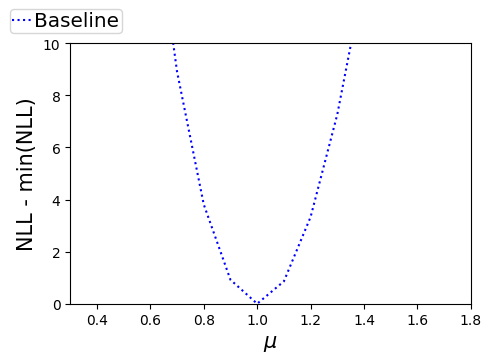

In [25]:
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_clf_nom-nll1D_clf_nom.min()],
                label_list=["Baseline", ], 
                color_list=[clfCol,], 
                linestyle_list=["dotted", ], 
              testDataLabel = "Nominal", ylimRatio=[0.75, 1.25], 
              legendOrder=[0], showLegend=True)
#plt.savefig(plotDir + "NLL_all_on_nominal.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

In [25]:
def ConfidenceIntervalls(mu_values, nll1D, central=1.0):
    z = np.polyfit(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1], 4)
    poly = np.poly1d(z)
    #1 Sigma = 0.5, 2 Sigma = 2, 3 Sigma = 4.5
    threshs = [0.5, 2.0, 4.5]
    sigmas = [1.0, 2.0, 3.0]
    ret_intersects = []
    std = 0.0
    
    for t,s  in zip(threshs, sigmas):
        intersects = (poly - t).roots
        # Select 2 roots closest to central value (only needed for polynomials with order > 2
        ret_intersects.append(intersects[np.argsort(np.abs(intersects-central))][:2])    
        std += (abs(ret_intersects[-1][0] - ret_intersects[-1][1])/(s*2))
        
    std = std/len(sigmas)
    
    #plt.plot(mu_values[(mu_values-central)<=1], nll1D[(mu_values-central)<=1])
    #plt.plot(np.linspace(central-1,central+1, 100), poly(np.linspace(0,2, 100)))
    return std, ret_intersects
    
sigma_clf_nom, _ = ConfidenceIntervalls(mu_values=mu_values, nll1D=nll1D_clf_nom-nll1D_clf_nom.min())


In [26]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 



### Single experiment x100


n_exp = 1000
n_data = 500000

X_sig_data = np.random.normal(0, feature_std, (n_exp, int(n_data*sigScaling), 2))
Y_sig_data = np.ones((n_exp, int(n_data*sigScaling)))

#Z_incarnation = np.random.normal(z_nominal, z_std, n_exp)
Z_incarnation = np.array([z_nominal])
centres_sig_data = np.expand_dims(r* np.vstack([np.cos(Z_incarnation), np.sin(Z_incarnation)]).T, 1)\

X_sig_data += centres_sig_data




X_back_data = np.random.normal(0, feature_std, (n_exp, int(n_data*backScaling), 2))
Y_back_data = np.zeros((n_exp, int(n_data*backScaling)))

centres_back_data = np.expand_dims(r* np.vstack([-np.cos(Z_incarnation), -np.sin(Z_incarnation)]).T, 1)

X_back_data += centres_back_data



X_data = np.concatenate([X_sig_data,X_back_data], 1)
Y_data = np.hstack([Y_sig_data,Y_back_data])
Z_data = np.zeros_like(Y_data) + np.expand_dims(Z_incarnation, 1)

weights_data = np.ones_like(Y_data)
#weights_data[Y_data==1] *=sigScaling
#weights_data[Y_data==0] *=backScaling



Y_predict_data = nominal_model.predict(X_data)


print(weights_data.shape, Y_predict_data.shape)

#sig_pred = np.sum(Y_predict_data > 0.5, 1)
#bkg_pred = Y_predict_data.shape[-1] - sig_pred

#mu = sig_pred/bkg_pred

(1000, 50500) (1000, 50500)


In [27]:

X_sig_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T])
Y_sig_syst_train = np.array([np.ones(n_data)])
centres_sig_syst_train = np.array([r* np.vstack([np.cos(z_nominal), np.sin(z_nominal)]).T])
X_sig_syst_train += centres_sig_syst_train

X_back_syst_train = np.array([np.vstack( [np.random.normal(0, feature_std, n_data), np.random.normal(0, feature_std, n_data)]).T])
Y_back_syst_train = np.array([np.zeros(n_data)])
centres_back_syst_train = np.array([r* np.vstack([-np.cos(z_nominal), -np.sin(z_nominal)]).T])
X_back_syst_train += centres_back_syst_train

X_syst_train = np.concatenate([X_sig_syst_train,X_back_syst_train], 1)
Y_syst_train = np.hstack([Y_sig_syst_train,Y_back_syst_train])


X_syst_train = X_syst_train.reshape(-1,X_syst_train.shape[-1])
Y_syst_train = Y_syst_train.reshape(-1)


weights_syst_train = np.ones_like(Y_syst_train)
weights_syst_train[Y_syst_train==1] *=sigScaling
weights_syst_train[Y_syst_train==0] *=backScaling


NameError: name 'syst_shifts_train' is not defined

In [29]:
mu_values1D = np.arange(0,50)/10



def buildTemplatesTrain(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    
    if not (clfName == "Aware"):
        if (clfName == "Invariant"):
            Y_pred_model = model.predict(X_syst_train, batch_size=4000).reshape(-1)
        elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
            if (clfName == "Augmented") and (~aug_NN):
                Y_pred_model = model.predict_proba(X_syst_train)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_train).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
    

    hist_sig, bin_array = np.histogram(
        Y_pred_model[(Y_syst_train==1)], 
        weights=weights_syst_train[(Y_syst_train==1)], range=(0,1), bins=nBins)
    hist_back, bin_array = np.histogram(
        Y_pred_model[(Y_syst_train==0)], 
        weights=weights_syst_train[(Y_syst_train==0)], range=(0,1), bins=nBins)

    sig_hists.append(hist_sig)
    back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists


# Build templates




def computeNLL2D_returnMu(obs1D, sH2d, bH2d, mu_values=mu_values1D):
    min_mu, min_z, minnll = 999,999,999999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for k,mu in enumerate(mu_values):
        for n,s,b in zip(obs1D, sH2d[0], bH2d[0]): # over the bins of score histo
            bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
            if (not np.isnan(bin_nll)):
                nll2D[k][0] += bin_nll
        if nll2D[k][0] < minnll:
            minnll = nll2D[k][0]
            min_mu = mu
    print ("Min at mu,z: ",min_mu)
    return nll2D, min_mu
        
        
def createHistObsPredicted(weights, Y_pred,):
    hist_obs, bin_array = np.histogram(Y_pred.reshape(-1), weights=weights.reshape(-1), range=(0,1), bins=nBins)
    return hist_obs, bin_array

        
#sig_hists, back_hists = buildTemplates(model=nominal_model, clfName="Nominal")
#sig_hists2, back_hists2 = buildTemplatesTrain(model=nominal_model, clfName="Nominal")


sig_hists_clf, back_hists_clf = buildTemplatesTrain(model=nominal_model, clfName="Nominal")
#sig_hists_awe, back_hists_awe = buildTemplatesTrain(model=nominal_model, clfName="Aware")

mus_clf = []
mus_awe = []



j = 1
for j in range(0, weights_data.shape[0]):
    
    hist_obs, bin_array = createHistObsPredicted(weights=weights_data[j:j+1], Y_pred=Y_predict_data[j:j+1])
    #hist_obs_awe2D = createHistObsAwe(X_data[j:j+1], weights=weights_data[j])

    
    nll2D_clf_data, min_mu_clf = computeNLL2D_returnMu(obs1D=hist_obs, sH2d=sig_hists_clf, bH2d=back_hists_clf)
    #nll2D_awe_data, min_mu_awe, min_z_awe = computeNLL2D_aware_returnMu(obs2D=hist_obs_awe2D, sH2d=sig_hists_awe, bH2d=back_hists_awe, z_syst_vals=z_syst_train)

    mus_clf.append(min_mu_clf)
    #mus_awe.append(min_mu_awe)
    

    
    
    




Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  0.9
Min at mu,z:  1.0
Min at mu,z:  0.8
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.1
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  1.2
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  1.0
Min at mu,z:  1.1
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,z:  1.1
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  1.0
Min at mu,z:  0.9
Min at mu,

0.06701872872563314 0.07327518749873822


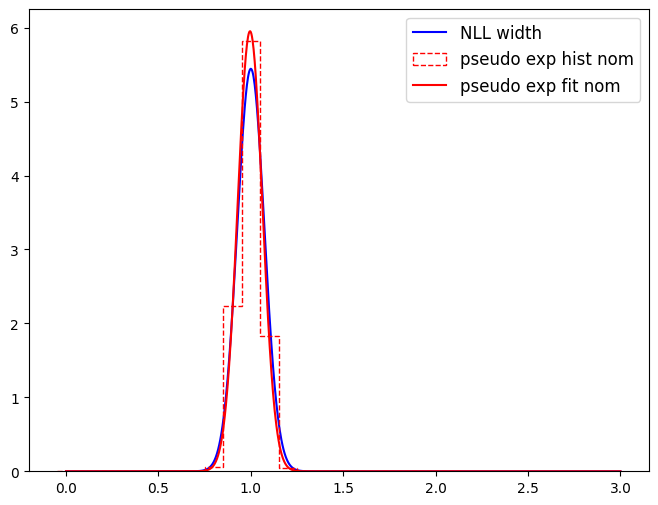

In [30]:
from scipy.stats import norm


fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)  

x_gauss = np.linspace(0.0, 3.0, 1000)
y_gauss = (norm.pdf((x_gauss-1)/sigma_clf_nom))/sigma_clf_nom

#sigma_clf_nom
#sigma_awe_nom

print(np.std(mus_clf), sigma_clf_nom)

y_gauss_fit = (norm.pdf((x_gauss-np.mean(mus_clf))/np.std(mus_clf)))/np.std(mus_clf)


subplot.plot(x_gauss, y_gauss, label='NLL width', color='b')
subplot.hist(mus_clf, bins=np.arange(-0.05, 2.25, 0.1), density = True, label='pseudo exp hist nom', histtype='step', color='r', ls='--')
subplot.plot(x_gauss, y_gauss_fit, label='pseudo exp fit nom', color='r')
subplot.legend(fontsize=12)




In [31]:
mus_clf = np.array(mus_clf)


cov_1sig = sum(abs(mus_clf-1) < sigma_clf_nom)/n_exp
cov_2sig = sum(abs(mus_clf-1) < sigma_clf_nom*2)/n_exp
cov_3sig = sum(abs(mus_clf-1) < sigma_clf_nom*3)/n_exp

print('1 Sigma: {:.2f} \n'.format(cov_1sig) + 
      '2 Sigma: {:.2f} \n'.format(cov_2sig) + 
      '3 Sigma: {:.2f} '.format(cov_3sig))

1 Sigma: 0.58 
2 Sigma: 0.99 
3 Sigma: 1.00 


In [ ]:
import 

data = 






